In [43]:
import pandas as pd

import os
import sys
import numpy as np

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# to save the audio files
import soundfile as sf

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [44]:
# Paths for data.
Ravdess = "datasets/Ravdess/audio_speech_actors_01-24/"
Crema = "datasets/Crema/"
Tess = "datasets/Tess/"
Savee = "datasets/Savee/"

# Trimming and combining (1sec)

In [45]:
ravdess_directory_list = os.listdir(Ravdess)
crema_directory_list = os.listdir(Crema)
tess_directory_list = os.listdir(Tess)
savee_directory_list = os.listdir(Savee)

input_path = "datasets/combined_2/"

segment_length = 1
sampling_rate = 22050
min_non_silent_duration = 0.5

ravdess_noise_reduction = 1
crema_noise_reduction = 5
tess_noise_reduction = 1
savee_noise_reduction = 1

ravdess_top_db = 30
crema_top_db = 30
tess_top_db = 60
savee_top_db = 25

In [46]:
def noise_reduction(audio, sr, noise_profile=None):
    # Compute the STFT of the signal
    stft = librosa.stft(audio)
    magnitude, phase = librosa.magphase(stft)

    # Estimate the noise profile if not provided
    if noise_profile is None:
        noise_profile = np.median(magnitude, axis=1, keepdims=True)

    # Subtract the noise profile from the magnitude
    magnitude_cleaned = np.maximum(magnitude - noise_profile, 0)

    # Reconstruct the audio signal from the cleaned magnitude and original phase
    stft_cleaned = magnitude_cleaned * phase
    audio_cleaned = librosa.istft(stft_cleaned)

    return audio_cleaned

## Ravdess

In [47]:
actor_counter = 0

# Loop through each file and get the length
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    actor_samples_counter = 0

    for file in actor:

        # dir = ravdess_directory_list[0]
        # file = os.listdir(Ravdess + dir)[0]

        part = file.split('.')[0]
        part = part.split('-')
        if int(part[2]) == 1 or int(part[2]) == 2:
            path = input_path + "neutral+calm/"
        elif int(part[2]) == 3:
            path = input_path + "happy/"
        elif int(part[2]) == 4:
            path = input_path + "sad/"
        elif int(part[2]) == 5:
            path = input_path + "angry/"
        elif int(part[2]) == 6:
            path = input_path + "fear/"
        elif int(part[2]) == 7:
            path = input_path + "disgust/"
        elif int(part[2]) == 8:
            path = input_path + "surprised/"
        else:
            path = input_path

        y, sr = librosa.load(Ravdess + dir + '/' + file)

        for i in range(ravdess_noise_reduction):
            y = noise_reduction(y, sr)

        y_trimmed, _ = librosa.effects.trim(y, top_db=ravdess_top_db)
        normalized_audio = librosa.util.normalize(y_trimmed)

        segment_length_samples = int(segment_length * sr)
        num_segments = -(-len(normalized_audio) // segment_length_samples)

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples
            segment = normalized_audio[start_sample:end_sample]

            seg_ln = librosa.get_duration(y=segment, sr=sr)
            if seg_ln >= min_non_silent_duration:
                if segment_length > seg_ln:
                    segment = librosa.util.fix_length(segment, size=sampling_rate)

                output_file_path = os.path.join(path, f'ravdess_{actor_counter}_{actor_samples_counter}_{i}.wav')
                sf.write(output_file_path, segment, sr)

        actor_samples_counter += 1
    actor_counter += 1


## Crema

In [48]:
file_counter = 0

for file in crema_directory_list:
    part = file.split('_')
    if part[2] == 'SAD':
        path = input_path + "sad/"
    elif part[2] == 'ANG':
        path = input_path + "angry/"
    elif part[2] == 'DIS':
        path = input_path + "disgust/"
    elif part[2] == 'FEA':
        path = input_path + "fear/"
    elif part[2] == 'HAP':
        path = input_path + "happy/"
    elif part[2] == 'NEU':
        path = input_path + "neutral+calm/"
    else:
        path = input_path

    y, sr = librosa.load(Crema + file)

    for i in range(crema_noise_reduction):
        y = noise_reduction(y, sr)

    y_trimmed, _ = librosa.effects.trim(y, top_db=crema_top_db)
    normalized_audio = librosa.util.normalize(y_trimmed)

    # Segment length in samples
    segment_length_samples = int(segment_length * sr)

    # Number of segments
    num_segments = -(-len(normalized_audio) // segment_length_samples)

    for i in range(num_segments):
        start_sample = i * segment_length_samples
        end_sample = start_sample + segment_length_samples
        segment = normalized_audio[start_sample:end_sample]

        seg_ln = librosa.get_duration(y=segment, sr=sr)
        if seg_ln >= min_non_silent_duration:
            if segment_length > seg_ln:
                segment = librosa.util.fix_length(segment, size=sampling_rate)

            output_file_path = os.path.join(path, f'crema_{file_counter}_{i}.wav')
            sf.write(output_file_path, segment, sr)

    file_counter += 1


## Tess

In [49]:
# tess
folder_counter = 0

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    file_counter = 0
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part == "angry":
            path = input_path + "angry/"
        elif part == "disgust":
            path = input_path + "disgust/"
        elif part == "fear":
            path = input_path + "fear/"
        elif part == "happy":
            path = input_path + "happy/"
        elif part == "neutral":
            path = input_path + "neutral+calm/"
        elif part == 'ps':
            path = input_path + "surprised/"
        elif part == 'sad':
            path = input_path + "sad/"
        else:
            path = input_path

        y, sr = librosa.load(Tess + dir + '/' + file)

        for i in range(tess_noise_reduction):
            y = noise_reduction(y, sr)

        y_trimmed, _ = librosa.effects.trim(y, top_db=tess_top_db)
        normalized_audio = librosa.util.normalize(y_trimmed)

        # Segment length in samples
        segment_length_samples = int(segment_length * sr)

        # Number of segments
        num_segments = -(-len(normalized_audio) // segment_length_samples)

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples
            segment = normalized_audio[start_sample:end_sample]

            seg_ln = librosa.get_duration(y=segment, sr=sr)
            if seg_ln >= min_non_silent_duration:
                if segment_length > seg_ln:
                    segment = librosa.util.fix_length(segment, size=sampling_rate)

                output_file_path = os.path.join(path, f'tess_{folder_counter}_{file_counter}_{i}.wav')
                sf.write(output_file_path, segment, sr)

        file_counter += 1
    folder_counter += 1

## Savee

In [8]:
# savee
file_counter = 0

for file in savee_directory_list:
    part = file.split('_')[1]
    ele = part[:-6]
    if ele == 'a':
        path = input_path + "angry/"
    elif ele == 'd':
        path = input_path + "disgust/"
    elif ele == 'f':
        path = input_path + "fear/"
    elif ele == 'h':
        path = input_path + "happy/"
    elif ele == 'n':
        path = input_path + "neutral+calm/"
    elif ele == 'sa':
        path = input_path + "sad/"
    elif ele == 'su':
        path = input_path + "surprised/"
    else:
        path = input_path

    y, sr = librosa.load(Savee + file)

    for i in range(savee_noise_reduction):
        y = noise_reduction(y, sr)

    y_trimmed, _ = librosa.effects.trim(y, top_db=savee_top_db)
    normalized_audio = librosa.util.normalize(y_trimmed)

    # Segment length in samples
    segment_length_samples = int(segment_length * sr)

    # Number of segments
    num_segments = -(-len(normalized_audio) // segment_length_samples)

    for i in range(num_segments):
        start_sample = i * segment_length_samples
        end_sample = start_sample + segment_length_samples
        segment = normalized_audio[start_sample:end_sample]

        seg_ln = librosa.get_duration(y=segment, sr=sr)
        if seg_ln >= min_non_silent_duration:
            if segment_length > seg_ln:
                segment = librosa.util.fix_length(segment, size=sampling_rate)

            output_file_path = os.path.join(path, f'savee_{file_counter}_{i}.wav')
            sf.write(output_file_path, segment, sr)

    file_counter += 1


# Data Augmentation

In [10]:
import librosa
import numpy as np
import random


# Individual augmentation functions
def pitch_shift(audio, sampling_rate, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sampling_rate, n_steps=n_steps)


def add_noise(audio, noise_factor):
    noise_amp = noise_factor * np.random.uniform() * np.amax(audio)
    audio = audio + noise_amp * np.random.normal(size=audio.shape[0])
    return audio


def frequency_masking(audio, sr, freq_mask_param=15):
    spectrogram = librosa.stft(audio)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

    freq_mask = np.random.randint(0, spectrogram_db.shape[0] - freq_mask_param)
    spectrogram_db[freq_mask:freq_mask + freq_mask_param, :] = 0

    masked_audio = librosa.istft(librosa.db_to_amplitude(spectrogram_db))
    return masked_audio


def time_masking(audio, sr, time_mask_param=30):
    spectrogram = librosa.stft(audio)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

    time_mask = np.random.randint(0, spectrogram_db.shape[1] - time_mask_param)
    spectrogram_db[:, time_mask:time_mask + time_mask_param] = 0

    masked_audio = librosa.istft(librosa.db_to_amplitude(spectrogram_db))
    return masked_audio


# Combination augmentation function
def combine_augmentations(audio, sr):
    if random.random() < 0.5:
        audio = pitch_shift(audio, sr, random.randint(-2, 2))
    if random.random() < 0.5:
        audio = add_noise(audio, 0.035)
    if random.random() < 0.5:
        audio = frequency_masking(audio, sr)
    if random.random() < 0.5:
        audio = time_masking(audio, sr)
    return audio


In [11]:
path = 'datasets/combined_L/surprised'
directory_list = os.listdir(path)
# file = directory_list[0]

for file in directory_list:
    y, sr = librosa.load(path + "/" + file)

    # Apply individual augmentations
    pitch_shifted_audio = pitch_shift(y, sr, 1)
    noisy_audio = add_noise(y, 0.035)
    # freq_masked_audio = frequency_masking(y, sr)
    # time_masked_audio = time_masking(y, sr)

    # Apply combination augmentations
    # combined_augmented_audio = combine_augmentations(y, sr)

    sf.write(os.path.join(path, f'shifted_{file}'), pitch_shifted_audio, sr)
    sf.write(os.path.join(path, f'noisy_{file}'), noisy_audio, sr)

    # pd.Series(pitch_shifted_audio).plot(figsize=(10, 5), lw=1, title='Raw audio data Tess (normalized)')
    # librosa.get_duration(y=pitch_shifted_audio, sr=sr)
    # Audio(pitch_shifted_audio, rate=sr)

## Feature extraction

In [88]:
import librosa.feature
import numpy as np


def extract_zcr(audio):
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    zcr_stats = np.concatenate([np.mean(zcr.T, axis=0), np.std(zcr.T, axis=0)])
    return zcr_stats


def extract_chroma(audio, sr):
    chroma = librosa.feature.chroma_stft(S=audio, sr=sr)
    chroma_stats = np.concatenate([np.mean(chroma.T, axis=0), np.std(chroma.T, axis=0)])
    return chroma_stats


def extract_mfccs(audio, sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_stats = np.concatenate([np.mean(mfccs.T, axis=0), np.std(mfccs.T, axis=0)])
    return mfcc_stats


def extract_spectral_contrast(audio, sr):
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    spectral_contrast_stats = np.concatenate(
        [np.mean(spectral_contrast.T, axis=0), np.std(spectral_contrast.T, axis=0)])
    return spectral_contrast_stats


def extract_spectral_rolloff(audio, sr):
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    spectral_rolloff_stats = np.concatenate([np.mean(spectral_rolloff.T, axis=0), np.std(spectral_rolloff.T, axis=0)])
    return spectral_rolloff_stats


def extract_rmse(audio):
    rmse = librosa.feature.rms(y=audio)
    rmse_stats = np.concatenate([np.mean(rmse.T, axis=0), np.std(rmse.T, axis=0)])
    return rmse_stats


def extract_mel_spectrogram(audio, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spectrogram_mean = np.mean(mel_spectrogram.T, axis=0)
    # mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram_db = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=16), ref=np.max)
    # print("extract_mel_spectrogram 2", mel_spectrogram.shape, mel_spectrogram_db.shape)
    # Do not reduce the Mel spectrogram to a mean; keep it as is
    return mel_spectrogram_db, mel_spectrogram_mean


def extract_features(data, sample_rate):
    result = np.array([])

    # ZCR
    zcr = extract_zcr(data)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = extract_chroma(stft, sample_rate)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = extract_mfccs(data, sample_rate)
    result = np.hstack((result, mfcc))

    # Spectral_contrast
    spectral_contrast = extract_spectral_contrast(data, sample_rate)
    result = np.hstack((result, spectral_contrast))

    # Spectral_rolloff
    spectral_rolloff = extract_spectral_rolloff(data, sample_rate)
    result = np.hstack((result, spectral_rolloff))

    # RMS
    rms = extract_rmse(data)
    result = np.hstack((result, rms))

    # Mel spectrogram
    mel_spectrogram, mel_spectrogram_mean = extract_mel_spectrogram(data, sample_rate)
    result = np.hstack((result, mel_spectrogram_mean))
    # print(mel_spectrogram.shape, mel_spectrogram.flatten().shape)
    # return result
    return result, mel_spectrogram.flatten()


def get_features(path):
    data, sample_rate = librosa.load(path)

    extracted_features, mel_spectrogram = extract_features(data, sample_rate)
    result = np.array(extracted_features)
    mel_spectrogram = np.array(mel_spectrogram)

    return result, mel_spectrogram

In [93]:
# features, mel_spectrogram = get_features("datasets/combined_2/angry/crema_0_0.wav")
# features = get_features("datasets/Crema/1001_DFA_ANG_XX.wav")
# features.shape, mel_spectrogram.shape


data, sample_rate = librosa.load("datasets/combined_2/angry/crema_0_0.wav")

mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=16)
# mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=32)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

mel_spectrogram_db.shape
# plt.figure(figsize=(10, 6))
# librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel', fmax=22050/2)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.show()


(16, 44)

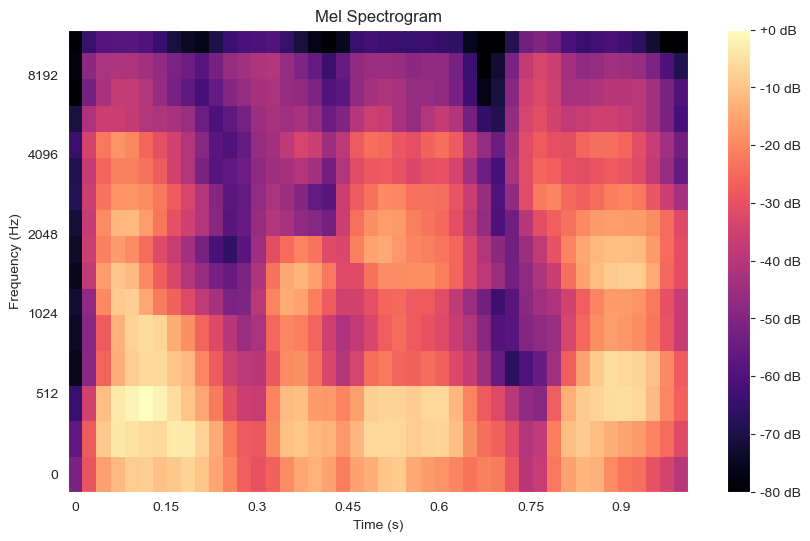

In [87]:
# features, mel_spectrogram = get_features("datasets/combined_2/angry/crema_0_0.wav")
# features = get_features("datasets/Crema/1001_DFA_ANG_XX.wav")
# features.shape, mel_spectrogram.shape


data, sample_rate = librosa.load("datasets/combined_2/angry/crema_0_0.wav")

# mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate)
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=16)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel', fmax=22050/2)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


In [89]:
import os
import numpy as np
import pandas as pd

path = "datasets/combined_2"
directory_list = os.listdir(path)
X_features = []
X_mel_sg = []
angry_labels = []
disgust_labels = []
fear_labels = []
happy_labels = []
neutral_labels = []
sad_labels = []
surprised_labels = []

for emotion in directory_list:
    angry_label = 0
    disgust_label = 0
    fear_label = 0
    happy_label = 0
    neutral_label = 0
    sad_label = 0
    surprised_label = 0
    match emotion:
        case "angry":
            angry_label = 1
        case "disgust":
            disgust_label = 1
        case "fear":
            fear_label = 1
        case "happy":
            happy_label = 1
        case "neutral+calm":
            neutral_label = 1
        case "sad":
            sad_label = 1
        case "surprised":
            surprised_label = 1

    samples = os.listdir(path + "/" + emotion)
    for sample in samples:
        features, mel_sgs = get_features(path + "/" + emotion + "/" + sample)
        # X_features.append(features)
        X_mel_sg.append(mel_sgs)
        
        angry_labels.append(angry_label)
        disgust_labels.append(disgust_label)
        fear_labels.append(fear_label)
        happy_labels.append(happy_label)
        neutral_labels.append(neutral_label)
        sad_labels.append(sad_label)
        surprised_labels.append(surprised_label)

# Features = pd.DataFrame(X_features)
# Features['angry'] = angry_labels
# Features['disgust'] = disgust_labels
# Features['fear'] = fear_labels
# Features['happy'] = happy_labels
# Features['neutral'] = neutral_labels
# Features['sad'] = sad_labels
# Features['surprised'] = surprised_labels
# Features.to_csv('datasets/dataset_2_1.csv', index=False)

Mel_sgs = pd.DataFrame(X_mel_sg)
Mel_sgs['angry'] = angry_labels
Mel_sgs['disgust'] = disgust_labels
Mel_sgs['fear'] = fear_labels
Mel_sgs['happy'] = happy_labels
Mel_sgs['neutral'] = neutral_labels
Mel_sgs['sad'] = sad_labels
Mel_sgs['surprised'] = surprised_labels
Mel_sgs.to_csv('datasets/dataset_2_2.csv', index=False)
# Features.head(), Mel_sgs.head()

In [38]:
Features.shape

(43830, 171)